In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import camb
from classy import Class # import classy module
from scipy.interpolate import interp1d
%matplotlib widget
log_folder = 'runs'

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('axes', titlesize=16)
rc('axes', labelsize=12)
rc('axes', axisbelow=False)
rc('lines',linewidth=1.5)
# lines.markersize : 10
rc('xtick', labelsize=13)
rc('xtick.major',size=10)
rc('xtick.minor',size=5)
rc('xtick',direction='in')
rc('ytick', labelsize=13)
rc('ytick.major',size=10)
rc('ytick.minor',size=5)
rc('ytick',direction='in')
# rc('legend',fontsize='large')

In [2]:
# import jax.profiler
# jax.profiler.start_server(9999)

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
from pylinger_background import evolve_background
from pylinger_perturbations import evolve_perturbations, determine_starting_time, determine_free_streaming_time, get_total_matter_fields

In [5]:
## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
OmegaDE = 1.0-Omegam
w_DE_0  = -0.99
w_DE_a  = 0.0
cs2_DE  = 1.0
num_massive_neutrinos = 1
mnu     = 0.006  #eV
Neff    = 2.046 # -1 if massive neutrino present
standard_neutrino_neff=Neff+num_massive_neutrinos
h       = 0.67742
A_s     = 2.1064e-09
n_s     = 0.96822
k_p     = 0.05

# modes to sample
nmodes = 256
kmin = 1e-5
kmax = 1e+2
aexp=0.01

In [6]:
# ## CAMB setup
pars = camb.CAMBparams()
#This function sets up with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=100*h, ombh2=Omegab*h**2, omch2=(Omegam-Omegab)*h**2, mnu=mnu, omk=0., 
                   tau=None, num_massive_neutrinos=num_massive_neutrinos, standard_neutrino_neff = Neff+num_massive_neutrinos,
                   nnu=Neff+num_massive_neutrinos, YHe=YHe, TCMB=Tcmb )
pars.set_dark_energy(w=w_DE_0, cs2=cs2_DE, wa=w_DE_a, dark_energy_model='fluid')
pars.InitPower.set_params(As=A_s, ns=n_s, r=0)
pars.set_accuracy(AccuracyBoost=2.0, lSampleBoost=2.0 , DoLateRadTruncation=False)
pars.set_matter_power(redshifts=[1/aexp-1], kmax=kmax/h*1.1, accurate_massive_neutrino_transfers=True)
results = camb.get_results(pars)
kh_camb, z_camb, pkbc_camb = results.get_matter_power_spectrum(minkh=kmin/h*1.01, maxkh=kmax/h*0.99, npoints = nmodes, var1='delta_nonu', var2='delta_nonu')
kh_camb, z_camb, pkm_camb  = results.get_matter_power_spectrum(minkh=kmin/h*1.01, maxkh=kmax/h*0.99, npoints = nmodes, var1='delta_tot', var2='delta_tot')
kh_camb, z_camb, pkc_camb = results.get_matter_power_spectrum(minkh=kmin/h*1.01, maxkh=kmax/h*0.99, npoints = nmodes, var1='delta_cdm', var2='delta_cdm')
kh_camb, z_camb, pkb_camb = results.get_matter_power_spectrum(minkh=kmin/h*1.01, maxkh=kmax/h*0.99, npoints = nmodes, var1='delta_baryon', var2='delta_baryon')
kh_camb, z_camb, pknu_camb = results.get_matter_power_spectrum(minkh=kmin/h*1.01, maxkh=kmax/h*0.99, npoints = nmodes, var1='delta_nu', var2='delta_nu')

print(z_camb)

[99.0]


In [7]:
## CLASS setup
# create instance of the class "Class"
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({
    'Omega_k':0.0,
    'Omega_b':Omegab,
    'Omega_cdm':(Omegam-Omegab),
    'N_ur':Neff,
    'N_ncdm':num_massive_neutrinos,
    'm_ncdm':mnu,
    'h':h,
    'A_s':A_s,
    'n_s':n_s,
    # 'tau_reio':0.06, 
    'gauge':'synchronous',
    'reio_parametrization' : 'reio_none',
    'k_per_decade_for_pk' : 100,
    'k_per_decade_for_bao' : 100,
    'compute damping scale' : 'yes',
    # 'tol_perturbations_integration' : 1e-07,
    # 'tol_background_integration' : 1e-07,
    # 'hyper_flat_approximation_nu' : 7000,
    'T_cmb':Tcmb,
    'YHe':YHe,
    'output':'mPk,mTk,vTk',
    'lensing':'no',
    'P_k_max_1/Mpc': kmax,
    'z_max_pk':1000.0,
    # # these are high precision reference settings
    # 'start_small_k_at_tau_c_over_tau_h' : 0.0015, #0.0004,
    # 'start_large_k_at_tau_h_over_tau_k' : 0.05,
    # 'tight_coupling_trigger_tau_c_over_tau_h' : 0.005,
    # 'tight_coupling_trigger_tau_c_over_tau_k' : 0.008,
    # 'start_sources_at_tau_c_over_tau_h' : 0.006,
    # 'l_max_g' : 50,
    # 'l_max_pol_g' : 25,
    # 'l_max_ur' : 50,
    # 'l_max_ncdm' : 50,
    'Omega_Lambda' : 0.0,
    'w0_fld' : w_DE_0,
    'wa_fld' : w_DE_a,
    'cs2_fld' : 1.0,
    'use_ppf' : 'no',
  })
# run class
LambdaCDM.compute()
thermo = LambdaCDM.get_thermodynamics()

def get_class_power( fieldname, zout ):
  tk, k, z = LambdaCDM.get_transfer_and_k_and_z()
  TT = interp1d( np.log(1/(1+z)), tk[fieldname], axis=1 )( np.log(1/(1+zout)) ) 
  # res =  2*np.pi**2*A_s*(k/k_p*h)**(n_s - 1) * k**(-3) * TT**2 
  res =  2*np.pi**2*A_s*(k/k_p)**(n_s - 1) * k**(-3) * TT**2
  return res, k

In [8]:
## Compute Background evolution
param = {}
param['Omegam']  = Omegam
param['Omegab']  = Omegab
param['OmegaDE'] = OmegaDE
param['w_DE_0']  = w_DE_0
param['w_DE_a']  = w_DE_a
param['cs2_DE']  = cs2_DE
param['Omegak']  = 0.0
param['A_s']     = A_s
param['n_s']     = n_s
param['H0']      = 100*h
param['Tcmb']    = Tcmb
param['YHe']     = YHe
param['Neff']    = Neff
param['Nmnu']    = num_massive_neutrinos
param['mnu']     = mnu

param = evolve_background(param=param)


In [9]:
nu_fluid_trigger_tau_over_tau_k            = 31.0   # value taken from default CLASS settings
radiation_streaming_trigger_tau_c_over_tau = 5.0    # value taken from CLASS
radiation_streaming_trigger_tau_over_tau_k = 45. #45.    # value taken from CLASS

kk = jnp.geomspace(1e-5,10,128)
tau_start = np.array([ jax.jit(determine_starting_time)(param=param,k=kp) for kp in kk])
tau_fa = np.array([ jnp.maximum(jax.jit(determine_free_streaming_time)(param=param, k=kp, radiation_streaming_trigger_tau_c_over_tau=radiation_streaming_trigger_tau_c_over_tau),radiation_streaming_trigger_tau_over_tau_k/kp) for kp in kk])


# tau_free_stream = determine_free_streaming_time( param=param, k=kmode,  radiation_streaming_trigger_tau_c_over_tau=radiation_streaming_trigger_tau_c_over_tau)
#     tau_free_stream = jnp.minimum( jnp.maximum( tau_free_stream, radiation_streaming_trigger_tau_over_tau_k/kmode ), tau_max )

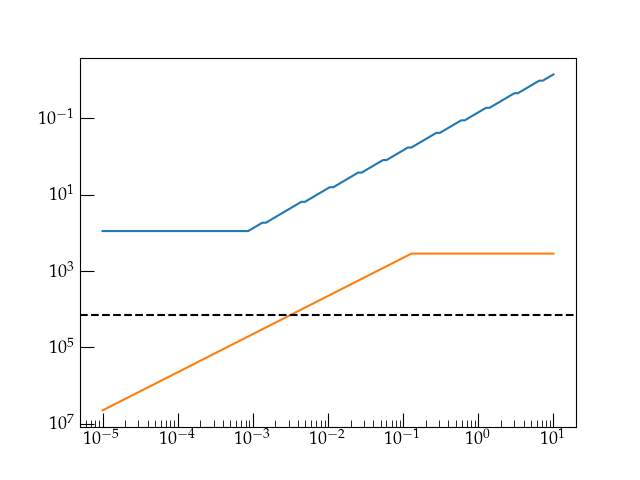

In [10]:
fig, ax = plt.subplots()
ax.loglog(kk, tau_start)
ax.loglog(kk, tau_fa)
ax.axhline(param['tau_of_a_spline'].evaluate(1.0),c='k',ls='--')

ax.invert_yaxis()

In [11]:
# Compute Perturbations

# aexp_out = jnp.array([1e-2,1e-1]) 
aexp_out = jnp.array([aexp]) #jnp.geomspace(1e-3,1,2)

y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
                                  # lmaxg=8,lmaxgp=8,lmaxr=8,lmaxnu=8,nqmax=8,
                                  # lmaxr = 11, lmaxg = 11, lmaxgp = 11, 
                                  # pcoeff = 0.0, icoeff = 1.0, dcoeff = 0.0, factormax = 10.0, factormin = 0.5,
                                  # pcoeff = 0.25, icoeff = 0.6, factormax = 20.0, factormin = 0.3, 
                                  #lmaxg = 25, lmaxgp = 25, lmaxr = 25, lmaxnu = 25, nqmax = 25,
                                  lmaxg = 31, lmaxgp = 31, lmaxr = 31, lmaxnu = 31, nqmax = 25,
                                  rtol=1e-4, atol=1e-4 )

iout = -1
fac = 2 * np.pi**2 * A_s
Pkc = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,3]**2
Pkb = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,5]**2
Pknu = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,7]**2

In [12]:
rhonu = param['rhonu_of_a_spline'].evaluate(aexp_out)

grhonu  = (param['grhor'] * param['Nmnu'] * rhonu) / aexp_out**4
grhom   = param['grhom'] / aexp_out**3
grhotot = Omegam * grhom #+ grhonu

fb  = Omegab * grhom / grhotot
fc  = (Omegam-Omegab) * grhom / grhotot
fnu = grhonu / grhotot

Pkbc = fb * Pkb + fc * Pkc
Pkm  = fb * Pkb + fc * Pkc + fnu * Pknu

# print(f'fb={fb}')

In [13]:
delta_m = np.zeros_like( kmodes )
delta_cb = np.zeros_like( kmodes )

res = [ get_total_matter_fields(y=yy[0],kmode=kk,param=param) for yy,kk in zip(y[:,:],kmodes) ]

for i,r in enumerate(res):
  delta_m[i] = r[0]
  delta_cb[i] = r[1]
  
Pkm = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * delta_m**2
Pkbc = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * delta_cb**2

In [14]:
zout = jnp.maximum(1/y[0,iout,0]-1,0.0)
print(f'z={zout}, aexp={aexp}')

Pkc_CLASS, k_CLASS = get_class_power('d_cdm', zout)
Pkb_CLASS, k_CLASS = get_class_power('d_b', zout)
Pknu_CLASS, k_CLASS = get_class_power('d_ncdm[0]', zout)
# Pkbc_CLASS = Omegab/Omegam * Pkb_CLASS + (Omegam-Omegab)/Omegam * Pkc_CLASS
Pkm_CLASS = np.array([LambdaCDM.pk_lin(ki, zout) for ki in k_CLASS])
Pkbc_CLASS = np.array([LambdaCDM.pk_cb_lin(ki, zout) for ki in k_CLASS])

z=99.01153718959404, aexp=0.01


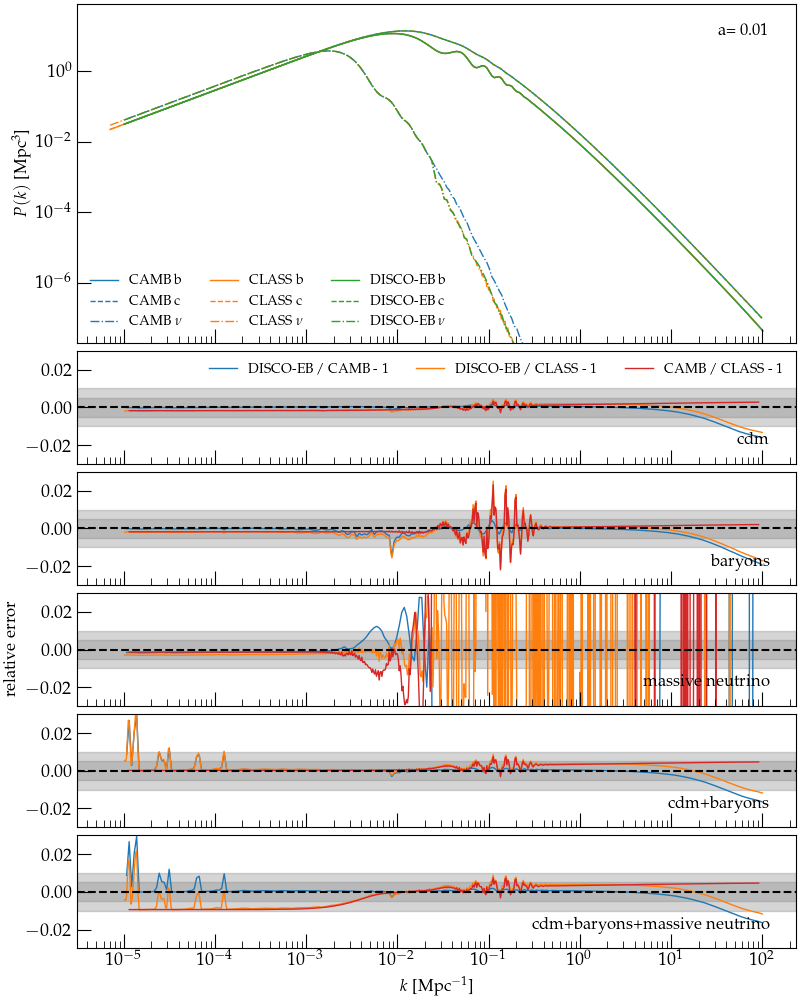

In [15]:
# fig, ax = plt.subplots()

# ax.loglog( kh_camb[1:]*h, pk_camb[0,1:]/h**3, label='CAMB' )
# ax.loglog( k_CLASS, Pkbc_CLASS, label='CLASS' )
# ax.loglog( kmodes, Pkbc, label='DISCO-EB' )

# plt.legend()

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1]}, layout='constrained', figsize=(8,10))

# ax1.loglog( kh_camb[1:]*h, pkbc_camb[0,1:]/h**3, label='CAMB c+b',lw=1, c='C0', ls = '-' )
# ax1.loglog( kh_camb[1:]*h, pkm_camb[0,1:]/h**3 / 10, label='CAMB c+b+$\\nu$ / 10',lw=1, c='C0', ls = '--' )


if False:

  ax1.axhline(1.0,lw=1.0,ls='--',c='k')

  ax1.plot( kh_camb[1:]*h, pkb_camb[0,1:]/pkm_camb[0,1:], label='CAMB b',lw=1, c='C0', ls = '-' )
  ax1.plot( kh_camb[1:]*h, pkc_camb[0,1:]/pkm_camb[0,1:], label='CAMB c',lw=1, c='C0', ls = '--' )
  ax1.plot( kh_camb[1:]*h, pknu_camb[0,1:]/pkm_camb[0,1:], label='CAMB $\\nu$',lw=1, c='C0', ls = '-.' )

  ax1.plot( k_CLASS, Pkb_CLASS / Pkm_CLASS, label='CLASS b',lw=1, c='C1', ls = '-' )
  ax1.plot( k_CLASS, Pkc_CLASS / Pkm_CLASS, label='CLASS c',lw=1, c='C1', ls = '--' )
  ax1.plot( k_CLASS, Pknu_CLASS / Pkm_CLASS, label='CLASS $\\nu$',lw=1, c='C1', ls = '-.' )

  ax1.plot( kmodes, Pkb / Pkm, label='DISCO-EB b', c='C2', lw=1, ls='-' )
  ax1.plot( kmodes, Pkc / Pkm, label='DISCO-EB c', c='C2', lw=1, ls='--' )
  ax1.plot( kmodes, Pknu / Pkm, label='DISCO-EB $\\nu$', c='C2', lw=1, ls='-.' )
  ax1.semilogx()
  ax1.set_ylim(0.0, 1.5)

else:
  ax1.plot( kh_camb[1:]*h, pkb_camb[0,1:] /h**3, label='CAMB b',lw=1, c='C0', ls = '-' )
  ax1.plot( kh_camb[1:]*h, pkc_camb[0,1:] /h**3, label='CAMB c',lw=1, c='C0', ls = '--' )
  ax1.plot( kh_camb[1:]*h, pknu_camb[0,1:] /h**3, label='CAMB $\\nu$',lw=1, c='C0', ls = '-.' )

  ax1.plot( k_CLASS, Pkb_CLASS, label='CLASS b',lw=1, c='C1', ls = '-' )
  ax1.plot( k_CLASS, Pkc_CLASS, label='CLASS c',lw=1, c='C1', ls = '--' )
  ax1.plot( k_CLASS, Pknu_CLASS, label='CLASS $\\nu$',lw=1, c='C1', ls = '-.' )

  ax1.plot( kmodes, Pkb, label='DISCO-EB b', c='C2', lw=1, ls='-' )
  ax1.plot( kmodes, Pkc, label='DISCO-EB c', c='C2', lw=1, ls='--' )
  ax1.plot( kmodes, Pknu, label='DISCO-EB $\\nu$', c='C2', lw=1, ls='-.' )

  ax1.loglog()
  ax1.set_ylim(2e-8, 80)

ax1.set_ylabel(r'$P(k)$ [Mpc$^{3}$]')
ax1.legend(frameon=False,ncol=3)
ax1.text(120,10, f'a={aexp : .2f}', fontsize=12, horizontalalignment='right')

def plot_resids( ax, k_CLASS, P_CLASS, k_CAMB, P_CAMB, k_DISCO, P_DISCO, labelstr ):
  iC = jnp.where( (k_CLASS > k_DISCO[0]) & (k_CLASS < k_DISCO[-1]) )[0]
  iC2 = jnp.where( (k_CLASS > k_CAMB[2]*h) & (k_CLASS < k_CAMB[-2]*h) )[0]

  # Interpolate the DISCO-EB curve to the same x-values as the other two curves
  f  = interp1d(jnp.log(k_DISCO), jnp.log(P_DISCO) )
  g  = interp1d(jnp.log(k_CAMB[1:]*h), jnp.log(P_CAMB[0,1:]/h**3) )
  P_interp_CAMB  = jnp.exp( f( jnp.log(k_CAMB[1:]*h) ) )
  P_interp_CLASS = jnp.exp( f( jnp.log(k_CLASS[iC]) ) )

  P_interp_CLASS_CAMB = jnp.exp( g( jnp.log(k_CLASS[iC2]) ) )

  # Plot the residual
  ax.semilogx(k_CAMB[1:]*h, (P_interp_CAMB - P_CAMB[0,1:]/h**3) / (P_CAMB[0,1:]/h**3), label='DISCO-EB / CAMB - 1', c='C0',lw=1)
  ax.semilogx(k_CLASS[iC], (P_interp_CLASS - P_CLASS[iC]) / P_CLASS[iC], label='DISCO-EB / CLASS - 1', c='C1',lw=1)
  ax.semilogx(k_CLASS[iC2], (P_interp_CLASS_CAMB - P_CLASS[iC2]) / P_CLASS[iC2], label='CAMB / CLASS - 1', c='C3',lw=1)
  ax.text(120,-0.02, labelstr, fontsize=12, horizontalalignment='right')
  return 

plot_resids( ax2, k_CLASS, Pkc_CLASS, kh_camb, pkc_camb, kmodes, Pkc, 'cdm')
plot_resids( ax3, k_CLASS, Pkb_CLASS, kh_camb, pkb_camb, kmodes, Pkb, 'baryons')
plot_resids( ax4, k_CLASS, Pknu_CLASS, kh_camb, pknu_camb, kmodes, Pknu, 'massive neutrino')
plot_resids( ax5, k_CLASS, Pkbc_CLASS, kh_camb, pkbc_camb, kmodes, Pkbc, 'cdm+baryons')
plot_resids( ax6, k_CLASS, Pkm_CLASS, kh_camb, pkm_camb, kmodes, Pkm, 'cdm+baryons+massive neutrino')
# plot_resids( ax4, k_CLASS, Pkb_CLASS, kh_camb, pkb_camb, kmodes, Pkb, 'b')


# # Interpolate the DISCO-EB curve to the same x-values as the other two curves
# f  = interp1d(jnp.log(kmodes), jnp.log(Pkm) )
# g  = interp1d(jnp.log(kh_camb[1:]*h), jnp.log(pkm_camb[0,1:]/h**3) )
# Pkm_interp_camb  = jnp.exp( f( jnp.log(kh_camb[1:]*h) ) )
# Pkm_interp_class = jnp.exp( f( jnp.log(k_CLASS[iC]) ) )

# Pkm_interp_class_camb = jnp.exp( g( jnp.log(k_CLASS[iC2]) ) )

# # Plot the residual
# ax3.semilogx(kh_camb[1:]*h, (Pkm_interp_camb - pkm_camb[0,1:]/h**3) / (pkm_camb[0,1:]/h**3), label='DISCO-EB / CAMB - 1', c='C0',lw=1)
# ax3.semilogx(k_CLASS[iC], (Pkm_interp_class - Pkm_CLASS[iC]) / Pkm_CLASS[iC], label='DISCO-EB / CLASS - 1', c='C1',lw=1)
# ax3.semilogx(k_CLASS[iC2], (Pkm_interp_class_camb - Pkm_CLASS[iC2]) / Pkm_CLASS[iC2], label='CAMB / CLASS - 1', c='C3',lw=1)
# ax3.text(30,-0.02, 'c+b+$\\nu$', fontsize=12)

for a in (ax2,ax3,ax4,ax5,ax6):

  a.axhline(0, color='k', ls='--')
  # add gray shaded area indicating per cent level residual
  a.axhspan(-0.01, 0.01, alpha=0.33, color='gray')
  a.axhspan(-0.005, 0.005, alpha=0.33, color='gray')
  a.set_ylim(-0.0299, 0.0299)  
  # a.set_ylabel('relative error')
ax2.legend(ncol=3,frameon=False)
  

ax4.set_ylabel('relative error')
ax6.set_xlabel(r'$k$ [Mpc$^{-1}$]')

plt.show()
# plt.savefig('comparison_class_camb.pdf',bbox_inches='tight')


In [16]:
## evaluate the power spectra
iout = -1
print(f'pyEB zout={1/y[0,iout,0]-1}')
zout = jnp.maximum(1/y[0,iout,0]-1,0.0)

Pkc = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,3]**2 
Pkb = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,5]**2 
Pkg = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,7]**2 

Pkc_CLASS, k_CLASS = get_class_power('d_cdm', zout)
Pkb_CLASS, k_CLASS = get_class_power('d_b', zout)

pyEB zout=99.01153718959404


(0.0001, 10)

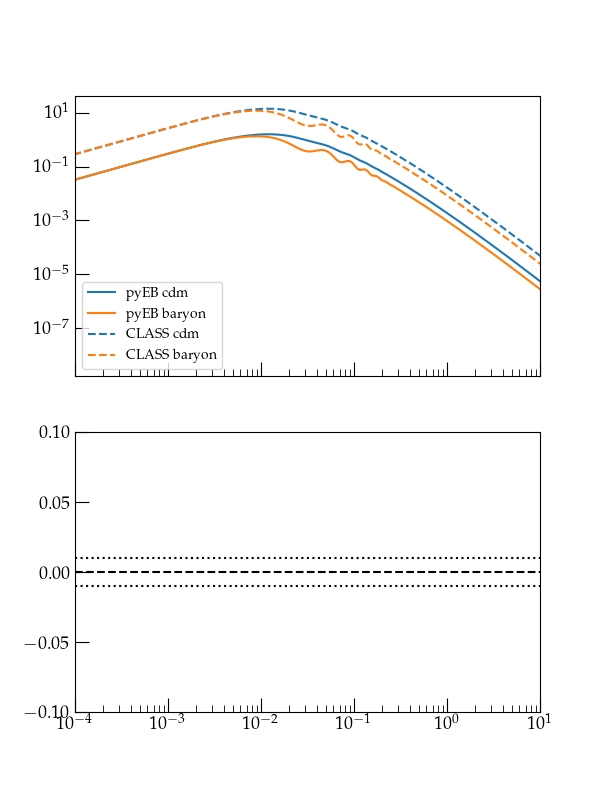

In [17]:
# plot power spectra against CLASS result

fig, ax = plt.subplots(2,1, sharex=True, figsize=(6,8) )
fac = 2.5 / 1.12
# fac = 2*np.pi**2/ (2*np.pi)**1.5 
ax[0].loglog( kmodes, Pkc*fac,label='pyEB cdm', color='C0')
# ax.loglog( kmodes, Pkc_CAMB, label='CAMB cdm', color='C0', ls='--')
ax[0].loglog( kmodes, Pkb*fac,label='pyEB baryon', color='C1') 
# ax.loglog( kmodes, Pkb_CAMB, label='CAMB baryon', color='C1', ls='--')
ax[0].loglog( k_CLASS, Pkc_CLASS, label='CLASS cdm', ls='--', color='C0')
ax[0].loglog( k_CLASS, Pkb_CLASS, label='CLASS baryon', ls='--', color='C1')
ax[0].legend()

ax[1].semilogx( kmodes, Pkc*fac/np.exp(np.interp( np.log(kmodes), np.log(k_CLASS), np.log(Pkc_CLASS) ))-1.0, label='cdm err', color='C0')
ax[1].semilogx( kmodes, Pkb*fac/np.exp(np.interp( np.log(kmodes), np.log(k_CLASS), np.log(Pkb_CLASS) ))-1.0, label='baryon err', color='C1')

ax[1].set_ylim((-0.1,0.1))
ax[1].axhline(0.0, ls='--', color='k')
ax[1].axhline(0.01, ls=':', color='k')
ax[1].axhline(-0.01, ls=':', color='k')

ax[1].set_xlim((1e-4,10))

# ax.loglog( kmodes, Pkg, label='pyEB photon', color='C2') 
# ax.set_xlim((1e-3,5))

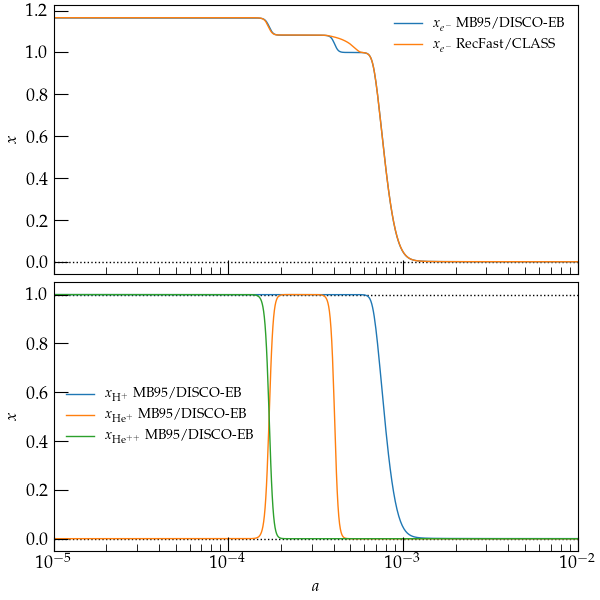

In [21]:
# plot thermal evolution
fg, ax = plt.subplots(2,sharex=True, layout='constrained', figsize=(6,6))
for a in ax:
  a.axhline(0.0,c='k',ls=':',lw=1)
ax[1].axhline(1.0,c='k',ls=':',lw=1)


ax[0].semilogx( param['th']['a'], param['th']['xe'], lw=1, label='$x_{e^-}$ MB95/DISCO-EB' )
ax[0].semilogx( 1/(1+thermo['z']), thermo['x_e'], lw=1, label='$x_{e^-}$ RecFast/CLASS' )
ax[1].semilogx( param['th']['a'], param['th']['xHII'], lw=1, label='$x_\\mathrm{H^{+}}$ MB95/DISCO-EB' )
ax[1].semilogx( param['th']['a'], param['th']['xHeII'], lw=1, label='$x_\\mathrm{He^{+}}$ MB95/DISCO-EB' )
ax[1].semilogx( param['th']['a'], param['th']['xHeIII'], lw=1, label='$x_\\mathrm{He^{++}}$ MB95/DISCO-EB' )
for a in ax: 
  a.legend(frameon=False)
  a.set_ylabel('$x$')
  a.set_xlim(1e-5,1e-2)
  
ax[1].set_xlabel('$a$')
plt.savefig('thermodynamics.pdf',bbox_inches='tight')

In [19]:
x = jnp.linspace(0,1,256)

f = jnp.ones((256,)*3) * x[:,None,None]
g = jnp.ones((256,)*3) * x[None,:,None]

f*g - f*jnp.transpose(f,(1,0,2))

Array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.